# ===========================================================
#  DF40 Deepfake Detection (ResNet50 + LIME)
# Works perfectly in Colab — TensorFlow 2.15 stable
# ===========================================================

# Uninstall existing packages to avoid conflicts

In [1]:
# Cell 1 — (Optional) try to install extras used by the notebook
# The installs are minimal. If any need a restart, the notebook will continue gracefully.
import sys
print("Python:", sys.version.splitlines()[0])

# Install extras that might be missing. These installs are optional; notebook continues if they fail.
# We don't pin many versions to avoid package conflicts.
!pip install --quiet lime scikit-image moviepy
!pip install --quiet tensorflow

# If you want OpenCV or other packages and they are missing, install:
!pip install --quiet opencv-python-headless
print("Install step finished. If an install required restarting the runtime, re-run this notebook from the top after restart.")

Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 10.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.5/29.5 MB 69.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 137.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 865.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 86.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 109.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 124.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━

# ============================================================
# Deepfake Detection Environment
# ============================================================


In [2]:
# Cell 2 — Imports and environment check
import os, shutil, math, zipfile, json, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Try to import machine learning frameworks (graceful errors if missing)
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers, models
    from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
    from tensorflow.keras.applications import ResNet50
    from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
    print("TensorFlow:", tf.__version__, "Keras:", keras.__version__)
except Exception as e:
    print("TensorFlow/Keras import failed:", e)
    print("If missing, install appropriate TensorFlow in Colab (default Colab provides TF).")

# scikit-learn
try:
    import sklearn
    from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score
    print("scikit-learn:", sklearn.__version__)
except Exception as e:
    print("scikit-learn import failed:", e)

# LIME (optional)
try:
    import lime
    from lime import lime_image
    from skimage.segmentation import mark_boundaries
    print("LIME available:", getattr(lime, "__version__", "unknown"))
    LIME_AVAILABLE = True
except Exception as e:
    print("LIME not available or import failed. Explanations will be skipped unless LIME is installed.")
    LIME_AVAILABLE = False

# plotting defaults
sns.set()
print("Working directory:", os.getcwd())


/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


TensorFlow: 2.20.0 Keras: 3.10.0
scikit-learn: 1.6.1
LIME available: unknown
Working directory: /content


# ============================================
# 0️⃣ Environment Setup
# ============================================


# ==============================================================
# 🎓 DF40 Deepfake Detection (ResNet50)
# - Uses runtime's TensorFlow/Keras to avoid version conflicts
# - Multi-class support for DF40
# - Optional LIME explainability (skips if unavailable)
# ==============================================================


In [3]:
# Cell 3 — Clone DF40 (if not already present) and inspect
if not os.path.exists("/content/DF40"):
    print("Cloning DF40 repository...")
    !git clone https://github.com/YZY-stack/DF40.git
else:
    print("DF40 already present.")

print("\nTop-level DF40 files:")
print(os.listdir("/content/DF40"))
print("\nLooking for image folders inside the repository...")

# Helper: find candidate image directory
def find_image_root(root="/content/DF40"):
    for d, subdirs, files in os.walk(root):
        img_count = sum(1 for f in files if f.lower().endswith(('.jpg','.jpeg','.png')))
        if img_count >= 10:
            return d
    return None

image_root = find_image_root("/content/DF40")
if image_root:
    print("Found image root inside DF40:", image_root)
else:
    print("No image folders with >=10 images found inside DF40.")
    print("If you have the DF40 image dataset (real/fake image folders), upload it or mount Google Drive in the next cell.")

Cloning DF40 repository...
Cloning into 'DF40'...
remote: Enumerating objects: 474, done.
remote: Counting objects: 100% (131/131), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 474 (delta 86), reused 47 (delta 46), pack-reused 343 (from 1)
Receiving objects: 100% (474/474), 105.06 MiB | 52.37 MiB/s, done.
Resolving deltas: 100% (189/189), done.

Top-level DF40 files:
['README.md', 'install.sh', '.git', 'DeepfakeBench_DF40', 'Annotations_for_Facial_Attributes', 'EFS_finetune_code', 'df40_figs']

Looking for image folders inside the repository...
Found image root inside DF40: /content/DF40/DeepfakeBench_DF40/training/lib/component/MCT


In [4]:
# Cell 4 — Provide dataset
# If we didn't find images inside the repo, prompt user to either:
#  - upload a zip that unzips into a folder with subfolders per class (e.g. 'real', 'fake' or multi-class)
#  - OR mount Google Drive and set a path

from google.colab import files, drive

if image_root:
    dataset_path = image_root
    print("Using dataset found in repo:", dataset_path)
else:
    print("No dataset found in repo. Choose one option below:")
    print("1) Upload a zip file containing dataset folder structured as: root/<class_name>/*.jpg")
    print("2) Mount Google Drive and set dataset path (recommended for large datasets)")

    # Try to mount Drive automatically if user consents
    mount = input("Type 'd' to mount Google Drive, 'u' to upload zip file, or ENTER to create a small synthetic demo dataset: ").strip().lower()
    if mount == 'd':
        print("Mounting Google Drive. Follow the authorization prompt.")
        drive.mount('/content/drive')
        # Ask user to input path in Drive
        dataset_path = input("Enter path to dataset directory in Drive (e.g. /content/drive/MyDrive/DF40_images): ").strip()
        if not os.path.exists(dataset_path):
            raise FileNotFoundError(f"{dataset_path} not found in Drive. Re-run and ensure path is correct.")
    elif mount == 'u':
        print("Upload a zip (will be extracted). Click the file picker.")
        uploaded = files.upload()
        # take first uploaded file
        zname = next(iter(uploaded))
        print("Uploaded:", zname)
        extract_to = "/content/df40_uploaded"
        os.makedirs(extract_to, exist_ok=True)
        with zipfile.ZipFile(zname, 'r') as z:
            z.extractall(extract_to)
        print("Extracted to", extract_to)
        dataset_path = find_image_root(extract_to) or extract_to
    else:
        # synthetic small demo dataset fallback
        print("Creating a tiny synthetic demo dataset at /content/df40_demo (two classes: real/fake).")
        demo_root = "/content/df40_demo"
        if os.path.exists(demo_root):
            shutil.rmtree(demo_root)
        os.makedirs(f"{demo_root}/real", exist_ok=True)
        os.makedirs(f"{demo_root}/fake", exist_ok=True)
        from tensorflow.keras.preprocessing.image import array_to_img
        for cls in ["real","fake"]:
            for i in range(80 if cls=="real" else 100):
                arr = np.random.rand(224,224,3)
                img = array_to_img(arr)
                img.save(f"{demo_root}/{cls}/img_{i+1}.jpg")
        dataset_path = demo_root
        print("Synthetic demo created at", dataset_path)

print("\nFinal dataset_path =", dataset_path)

Using dataset found in repo: /content/DF40/DeepfakeBench_DF40/training/lib/component/MCT

Final dataset_path = /content/DF40/DeepfakeBench_DF40/training/lib/component/MCT


In [5]:
# Cell 5 — Path of the dataset
print("dataset_path =", dataset_path)
for root, dirs, files in os.walk(dataset_path):
    print("FOLDER:", root)
    print("   Subfolders:", dirs)
    print("   Images:", [f for f in files[:5] if f.lower().endswith(('.jpg','.png'))])
    break

dataset_path = /content/DF40/DeepfakeBench_DF40/training/lib/component/MCT
FOLDER: /content/DF40/DeepfakeBench_DF40/training/lib/component/MCT
   Subfolders: []
   Images: ['template9.png', 'template4.png', 'template7.png', 'template2.png', 'template0.png']


In [6]:
# Cell 6 — Create Synthetic dataset
import os, shutil, numpy as np
from tensorflow.keras.preprocessing.image import array_to_img

data_root = "/content/df40_demo"
if os.path.exists(data_root):
    shutil.rmtree(data_root)
os.makedirs(f"{data_root}/real", exist_ok=True)
os.makedirs(f"{data_root}/fake", exist_ok=True)

for cls in ["real", "fake"]:
    for i in range(80 if cls == "real" else 100):
        arr = np.random.rand(224,224,3)
        img = array_to_img(arr)
        img.save(f"{data_root}/{cls}/img_{i+1}.jpg")

print(f"Synthetic dataset ready at: {data_root}")
dataset_path = data_root

Synthetic dataset ready at: /content/df40_demo


In [7]:
# Cell 7 — Data generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (224,224)
BATCH = 16
VAL_SPLIT = 0.2

# confirm dataset_path exists
if not os.path.exists(dataset_path):
    raise FileNotFoundError("Dataset path not found:", dataset_path)

# detect classes
classes = [d for d in sorted(os.listdir(dataset_path)) if os.path.isdir(os.path.join(dataset_path,d))]
if len(classes) == 0:
    raise ValueError("No class subfolders found in dataset root. Structure should be root/<class_name>/*.jpg")

print("Detected class folders:", classes)

datagen = ImageDataGenerator(rescale=1./255, validation_split=VAL_SPLIT,
                             horizontal_flip=True, rotation_range=10)

# choose class_mode and loss later based on num_classes
train_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode='categorical' if len(classes)>2 else 'binary',
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH,
    class_mode='categorical' if len(classes)>2 else 'binary',
    subset='validation',
    shuffle=False
)

num_classes = len(train_gen.class_indices)
print("Num classes:", num_classes, "| class indices:", train_gen.class_indices)

Detected class folders: ['fake', 'real']
Found 144 images belonging to 2 classes.
Found 36 images belonging to 2 classes.
Num classes: 2 | class indices: {'fake': 0, 'real': 1}


In [8]:
# Cell 8 — Build ResNet50-based model
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid') if num_classes==2 else layers.Dense(num_classes, activation='softmax')
])

loss = 'binary_crossentropy' if num_classes==2 else 'categorical_crossentropy'
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [9]:
# Cell 9 — Training
EPOCHS = 30
steps_per_epoch = max(1, train_gen.samples // BATCH)
validation_steps = max(1, val_gen.samples // BATCH)

checkpoint_path = "/content/best_df_model.h5"
callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, save_weights_only=False)
]

history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=EPOCHS,
    callbacks=callbacks
)
print("\nTraining finished. Best model (if saved) at:\n", checkpoint_path)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3765 - loss: 0.8821

9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.3805 - loss: 0.8815 - val_accuracy: 0.6250 - val_loss: 0.6692
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5579 - loss: 0.6920 - val_accuracy: 0.3750 - val_loss: 0.7521
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5937 - loss: 0.7376

9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5892 - loss: 0.7405 - val_accuracy: 0.6250 - val_loss: 0.6628
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4795 - loss: 0.7312 - val_accuracy: 0.6250 - val_loss: 0.6799
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5295 - loss: 0.7296 - val_accuracy: 0.6250 - val_loss: 0.6648
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5374 - loss: 0.6871 - val_accuracy: 0.6250 - val_loss: 0.6673
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5367 - loss: 0.7013 - val_accuracy: 0.6250 - val_loss: 0.6725
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5672 - loss: 0.6850 - val_accuracy: 0.6250 - val_loss: 0.6747
Epoch 9/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5921 - loss: 0.6801 - val_accuracy: 0.3750 - val_loss: 0.7007
Epoch 10/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4378 - loss: 0.7432

9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4440 - loss: 0.7430 - val_accuracy: 0.6250 - val_loss: 0.6613
Epoch 11/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5891 - loss: 0.7082 - val_accuracy: 0.6250 - val_loss: 0.6764
Epoch 12/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4633 - loss: 0.7121 - val_accuracy: 0.6250 - val_loss: 0.6632
Epoch 13/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5161 - loss: 0.6906 - val_accuracy: 0.6250 - val_loss: 0.6683
Epoch 14/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5154 - loss: 0.7169 - val_accuracy: 0.6250 - val_loss: 0.6819
Epoch 15/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5252 - loss: 0.6969 - val_accuracy: 0.6250 - val_loss: 0.6622
Epoch 16/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5816 - loss: 0.6595 - val_accuracy: 0.6250 - val_loss: 0.6742
Epoch 17/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4453 - loss: 0.7227 - val_accuracy: 0.6250 - val_loss: 0.6737
Epoch 18/30


| Objective                                                                      | Recommended Plot                                        | Explanation                                                                                          |
| ------------------------------------------------------------------------------ | ------------------------------------------------------- | ---------------------------------------------------------------------------------------------------- |
| ✅ **Image-level distribution**                                                 | **Bar Plot / Count Plot**                               | Show how many samples are `real` vs `fake`. Useful for class balance.                                |
| 📊 **Pixel intensity or color distribution**                                   | **Histogram**                                           | Helps check exposure or color bias (e.g. fake images may have smoother histograms).                  |
| 🧬 **Feature correlation** (numerical features from annotations or embeddings) | **Heatmap (Correlation Matrix)**                        | Shows how different numerical features relate — e.g. face angle, compression, luminance.             |
| 🌌 **Feature embeddings or high-dimensional visualization**                    | **Scatter Plot (2D Projection via PCA / t-SNE / UMAP)** | Useful to visualize how deepfake and real embeddings cluster apart.                                  |
| 🔥 **Model confusion**                                                         | **Confusion Matrix Heatmap**                            | After classification, shows which class is confused with which — standard for binary classification. |
| 📈 **Model training performance**                                              | **Line Plot (Accuracy/Loss vs Epoch)**                  | To visualize convergence and overfitting during training.                                            |
| 🧠 **Explainability**                                                          | **LIME / Grad-CAM heatmaps on faces**                   | Visual overlay showing which parts of the face influenced the model’s decision.                      |


🎯 So, in DF40:

You’ll likely use a combination of:

Bar plot → to check class distribution.

Histogram → for color/intensity distribution analysis.

Scatter plot / t-SNE → to visualize learned feature separations between real vs fake.

Heatmap → for confusion matrix or correlation of numerical metadata.

Grad-CAM / LIME → for visual explainability on faces.

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step

Classification Report:
               precision    recall  f1-score   support

        fake       0.56      1.00      0.71        20
        real       0.00      0.00      0.00        16

    accuracy                           0.56        36
   macro avg       0.28      0.50      0.36        36
weighted avg       0.31      0.56      0.40        36



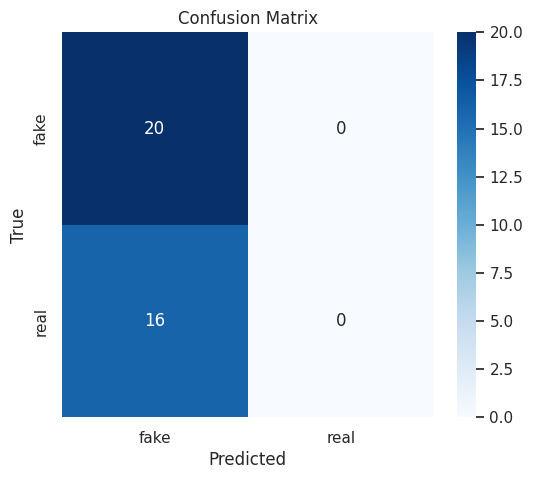

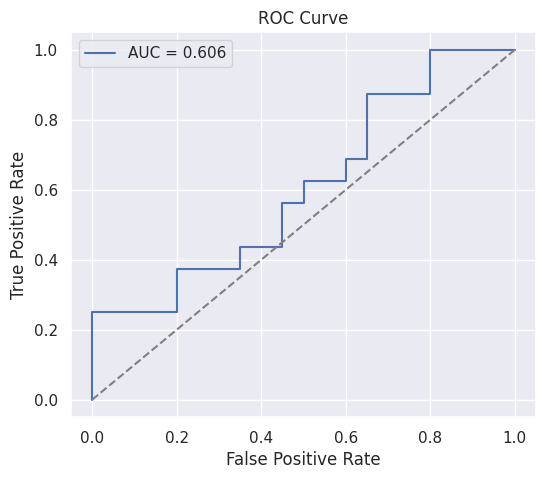

Saved report to /content/training_report.txt


In [10]:
# Cell 10 — Evaluate, metrics, plots and produce report
# predict across entire validation set


val_steps_all = math.ceil(val_gen.samples / BATCH)
preds = model.predict(val_gen, steps=val_steps_all, verbose=1)
if num_classes == 2:
    y_pred = (preds.ravel() > 0.5).astype(int)
    y_scores = preds.ravel()
else:
    y_pred = np.argmax(preds, axis=1)
    y_scores = preds  # multi-class scores

y_true = val_gen.classes[:len(y_pred)]

# Classification report
target_names = list(train_gen.class_indices.keys())
report_text = classification_report(y_true, y_pred, target_names=target_names, zero_division=0)
print("\nClassification Report:\n", report_text)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ROC/AUC for binary
if num_classes==2:
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
    plt.plot([0,1],[0,1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("ROC Curve"); plt.legend(); plt.show()
else:
    print("ROC/AUC plotting skipped for multi-class (use one-vs-rest if desired).")

# Save textual report
report_path = "/content/training_report.txt"
with open(report_path, "w") as f:
    f.write("Classification Report\n")
    f.write(report_text + "\n\n")
    f.write("Confusion Matrix\n")
    f.write(np.array2string(cm) + "\n\n")
    if num_classes==2:
        f.write(f"ROC AUC = {roc_auc:.6f}\n")
print("Saved report to", report_path)

Explaining image: /content/df40_demo/fake/img_1.jpg


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step


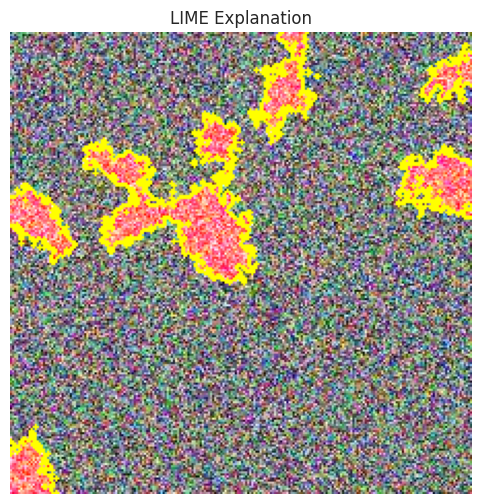

In [11]:
# Cell 11 — LIME explainability (runs only if LIME and scikit-image available)
if not LIME_AVAILABLE:
    print("LIME not available. To enable LIME, run: !pip install lime scikit-image  then restart runtime and re-run from start.")
else:
    try:
        # explain a single validation image
        explain_idx = 0
        img_path = val_gen.filepaths[explain_idx]
        print("Explaining image:", img_path)
        img = load_img(img_path, target_size=IMG_SIZE)
        img_arr = img_to_array(img) / 255.0

        explainer = lime_image.LimeImageExplainer()
        # classifier function expects batch of images in model's input format
        def batch_predict(images):
            images = np.array(images)
            return model.predict(images)

        explanation = explainer.explain_instance(np.uint8(img_arr*255), batch_predict, top_labels=1, hide_color=0, num_samples=200)
        label = explanation.top_labels[0]
        temp, mask = explanation.get_image_and_mask(label, positive_only=False, num_features=10, hide_rest=False)
        plt.figure(figsize=(6,6))
        plt.imshow(mark_boundaries(temp/255.0, mask))
        plt.axis('off')
        plt.title("LIME Explanation")
        plt.show()
    except Exception as e:
        print("LIME failed during explanation:", e)
        print("You can install compatible versions then restart runtime: !pip install lime scikit-image")

In [12]:
# Cell 12 — model build
# ===== Replace / Paste this cell into your notebook =====
from sklearn.utils import class_weight

# --- Config (tweak these) ---
IMG_SIZE = (224,224)
BATCH_SIZE = getattr(globals(), "BATCH_SIZE", 16)
EPOCHS = 25
PATIENCE = 6
MODEL_DIR = "/content/models"
os.makedirs(MODEL_DIR, exist_ok=True)

# --- Focal loss (optional) ---
def focal_loss(gamma=2., alpha=0.25):
    # Works for binary classification (sigmoid). For multi-class you can adapt.
    def fl(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        modulating_factor = tf.pow(1.0 - p_t, gamma)
        return alpha_factor * modulating_factor * bce
    return fl

# --- Model builder: fine_tune_at = number of layers from the top of base to unfreeze.
def build_model(num_classes,
                fine_tune_at=50,        # unfreeze last N layers of base
                dense_units=512,
                dropout_rate=0.5,
                lr=1e-4,
                use_focal=False):
    base = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0],IMG_SIZE[1],3))
    # Freeze all first
    base.trainable = True
    # Freeze up to len(base.layers)-fine_tune_at
    if isinstance(fine_tune_at, int) and fine_tune_at > 0:
        for layer in base.layers[:-fine_tune_at]:
            layer.trainable = False
    else:
        # if 0, freeze whole base (transfer learning only)
        for layer in base.layers:
            layer.trainable = False

    inputs = keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    x = base(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(dense_units, activation='relu', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    # second dense (gives more capacity)
    x = layers.Dense(max(128, dense_units//2), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate*0.6)(x)

    if num_classes == 2:
        outputs = layers.Dense(1, activation='sigmoid')(x)
    else:
        outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs, name="resnet50_finetune")
    # loss
    if use_focal and num_classes==2:
        loss = focal_loss()
    else:
        loss = 'binary_crossentropy' if num_classes==2 else 'categorical_crossentropy'

    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy', keras.metrics.AUC(name='auc')])
    return model

# --- Prepare class weights (if binary) ---
try:
    y_train = train_gen.classes   # flows have .classes
    class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
    class_weights = {i: w for i, w in enumerate(class_weights)}
    print("Using class_weights:", class_weights)
except Exception as e:
    print("Could not compute class weights, proceeding without. Error:", e)
    class_weights = None

# --- Callbacks ---
ts = int(time.time())
checkpoint_path = os.path.join(MODEL_DIR, f"best_model_{ts}.keras")
callbacks = [
    ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1),
]

# --- Data augmentation tuning (if you use ImageDataGenerator above, it's applied).
# If you'd like stronger augmentation, you can wrap train dataset with tf.data and augment there.
# For now assume train_gen / val_gen already exist (ImageDataGenerator.flow_from_directory).

num_classes = len(train_gen.class_indices)
print("Num classes:", num_classes)

# --- Quick manual hyper-parameter sweep (cheap): try a few combinations
grid = [
    {"dense_units":256, "dropout_rate":0.4, "fine_tune_at":0, "lr":1e-4},
    {"dense_units":256, "dropout_rate":0.4, "fine_tune_at":30, "lr":5e-5},
    {"dense_units":512, "dropout_rate":0.5, "fine_tune_at":30, "lr":5e-5},
    {"dense_units":512, "dropout_rate":0.5, "fine_tune_at":80, "lr":2e-5},
]

results = []
for cfg in grid:
    print("\n--- Training with cfg:", cfg)
    model = build_model(num_classes=num_classes,
                        fine_tune_at=cfg["fine_tune_at"],
                        dense_units=cfg["dense_units"],
                        dropout_rate=cfg["dropout_rate"],
                        lr=cfg["lr"],
                        use_focal=False)   # try focal=True if imbalance and binary
    # summary small
    model.summary()

    # small quick-run epochs for hyper-search (you can increase for final)
    quick_epochs = 10
    try:
        history = model.fit(
            train_gen,
            validation_data=val_gen,
            epochs=quick_epochs,
            class_weight=class_weights if class_weights else None,
            callbacks=callbacks,
            verbose=2
        )
    except Exception as e:
        print("Training error:", e)
        continue

    val_acc = history.history.get('val_accuracy', [0])[-1]
    results.append((cfg, val_acc, checkpoint_path))
    print("cfg result val_acc:", val_acc)

# Choose best cfg by highest val_acc
best = max(results, key=lambda x: x[1]) if results else None
print("GRID RESULTS:", results)
print("Best:", best)

# --- If we have a best, reload best and continue training for longer ---
if best:
    best_cfg = best[0]
    final_model = build_model(num_classes=num_classes,
                              fine_tune_at=best_cfg["fine_tune_at"],
                              dense_units=best_cfg["dense_units"],
                              dropout_rate=best_cfg["dropout_rate"],
                              lr=best_cfg["lr"],
                              use_focal=False)
    # load weights saved by ModelCheckpoint if present
    try:
        final_model.load_weights(checkpoint_path)
        print("Loaded best checkpoint.")
    except Exception as e:
        print("Could not load checkpoint:", e)

    # Longer training
    final_history = final_model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=EPOCHS,
        class_weight=class_weights if class_weights else None,
        callbacks=callbacks,
        verbose=2
    )

    # Save final
    final_path = os.path.join(MODEL_DIR, f"final_model_{ts}.keras")
    final_model.save(final_path)
    print("Final model saved to:", final_path)
else:
    print("No successful trainings in grid - re-run with adjusted grid or check dataset.")

Could not compute class weights, proceeding without. Error: too many positional arguments
Num classes: 2

--- Training with cfg: {'dense_units': 256, 'dropout_rate': 0.4, 'fine_tune_at': 0, 'lr': 0.0001}


Model: "resnet50_finetune"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,155,009 (92.14 MB)

 Trainable params: 562,433 (2.15 MB)

 Non-trainable params: 23,592,576 (90.00 MB)

Epoch 1/10

Epoch 1: val_accuracy improved from -inf to 0.55556, saving model to /content/models/best_model_1762697016.keras
9/9 - 20s - 2s/step - accuracy: 0.5139 - auc: 0.5109 - loss: 0.9175 - val_accuracy: 0.5556 - val_auc: 0.4531 - val_loss: 0.6873 - learning_rate: 1.0000e-04
Epoch 2/10

Epoch 2: val_accuracy did not improve from 0.55556
9/9 - 12s - 1s/step - accuracy: 0.4583 - auc: 0.5041 - loss: 0.8822 - val_accuracy: 0.5556 - val_auc: 0.4734 - val_loss: 0.6878 - learning_rate: 1.0000e-04
Epoch 3/10

Epoch 3: val_accuracy did not improve from 0.55556
9/9 - 12s - 1s/step - accuracy: 0.5694 - auc: 0.5489 - loss: 0.8815 - val_accuracy: 0.5556 - val_auc: 0.3875 - val_loss: 0.6877 - learning_rate: 1.0000e-04
Epoch 4/10

Epoch 4: val_accuracy did not improve from 0.55556

Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
9/9 - 12s - 1s/step - accuracy: 0.4792 - auc: 0.4662 - loss: 0.9124 - val_accuracy: 0.5556 - val_auc: 0.5047 - val_loss: 0.6878 - learning_ra

Model: "resnet50_finetune"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,155,009 (92.14 MB)

 Trainable params: 15,012,609 (57.27 MB)

 Non-trainable params: 9,142,400 (34.88 MB)

Epoch 1/10

Epoch 1: val_accuracy did not improve from 0.55556
9/9 - 27s - 3s/step - accuracy: 0.4653 - auc: 0.4861 - loss: 0.9641 - val_accuracy: 0.4444 - val_auc: 0.6125 - val_loss: 0.6989 - learning_rate: 5.0000e-05
Epoch 2/10

Epoch 2: val_accuracy did not improve from 0.55556
9/9 - 17s - 2s/step - accuracy: 0.4653 - auc: 0.4773 - loss: 0.9007 - val_accuracy: 0.4444 - val_auc: 0.4500 - val_loss: 0.7076 - learning_rate: 5.0000e-05
Epoch 3/10

Epoch 3: val_accuracy did not improve from 0.55556
9/9 - 17s - 2s/step - accuracy: 0.4861 - auc: 0.4280 - loss: 1.0023 - val_accuracy: 0.4444 - val_auc: 0.4766 - val_loss: 0.7142 - learning_rate: 5.0000e-05
Epoch 4/10

Epoch 4: val_accuracy did not improve from 0.55556

Epoch 4: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
9/9 - 17s - 2s/step - accuracy: 0.5069 - auc: 0.5002 - loss: 0.9510 - val_accuracy: 0.4444 - val_auc: 0.4437 - val_loss: 0.7235 - learning_rate: 5.0000e-05
Epoch 5/10

Epoch 5: val_accuracy did not impro

Model: "resnet50_finetune"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,779,649 (94.53 MB)

 Trainable params: 15,636,481 (59.65 MB)

 Non-trainable params: 9,143,168 (34.88 MB)

Epoch 1/10

Epoch 1: val_accuracy did not improve from 0.55556
9/9 - 26s - 3s/step - accuracy: 0.4722 - auc: 0.4607 - loss: 1.0659 - val_accuracy: 0.5556 - val_auc: 0.4891 - val_loss: 0.6874 - learning_rate: 5.0000e-05
Epoch 2/10

Epoch 2: val_accuracy did not improve from 0.55556
9/9 - 17s - 2s/step - accuracy: 0.5417 - auc: 0.5701 - loss: 0.8968 - val_accuracy: 0.5556 - val_auc: 0.4688 - val_loss: 0.6875 - learning_rate: 5.0000e-05
Epoch 3/10

Epoch 3: val_accuracy did not improve from 0.55556
9/9 - 17s - 2s/step - accuracy: 0.5694 - auc: 0.6120 - loss: 0.8669 - val_accuracy: 0.5556 - val_auc: 0.4172 - val_loss: 0.6884 - learning_rate: 5.0000e-05
Epoch 4/10

Epoch 4: val_accuracy did not improve from 0.55556

Epoch 4: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
9/9 - 17s - 2s/step - accuracy: 0.5278 - auc: 0.6252 - loss: 0.8164 - val_accuracy: 0.5556 - val_auc: 0.4250 - val_loss: 0.6885 - learning_rate: 5.0000e-05
Epoch 5/10

Epoch 5: val_accuracy did not impro

Model: "resnet50_finetune"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,779,649 (94.53 MB)

 Trainable params: 21,492,993 (81.99 MB)

 Non-trainable params: 3,286,656 (12.54 MB)

Epoch 1/10

Epoch 1: val_accuracy did not improve from 0.55556
9/9 - 39s - 4s/step - accuracy: 0.4722 - auc: 0.4553 - loss: 1.0424 - val_accuracy: 0.4444 - val_auc: 0.4938 - val_loss: 0.7734 - learning_rate: 2.0000e-05
Epoch 2/10

Epoch 2: val_accuracy did not improve from 0.55556
9/9 - 25s - 3s/step - accuracy: 0.4931 - auc: 0.4783 - loss: 0.9528 - val_accuracy: 0.4444 - val_auc: 0.4156 - val_loss: 0.7469 - learning_rate: 2.0000e-05
Epoch 3/10

Epoch 3: val_accuracy did not improve from 0.55556
9/9 - 24s - 3s/step - accuracy: 0.4583 - auc: 0.4810 - loss: 1.0292 - val_accuracy: 0.4444 - val_auc: 0.6422 - val_loss: 0.7204 - learning_rate: 2.0000e-05
Epoch 4/10

Epoch 4: val_accuracy did not improve from 0.55556
9/9 - 24s - 3s/step - accuracy: 0.4861 - auc: 0.4966 - loss: 0.9346 - val_accuracy: 0.4444 - val_auc: 0.4688 - val_loss: 0.7085 - learning_rate: 2.0000e-05
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.55556
9/9 - 24s - 3s/step - accuracy: 0.5208 - auc: 0.5232 - loss: 

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Loaded best checkpoint.
Epoch 1/25

Epoch 1: val_accuracy did not improve from 0.55556
9/9 - 19s - 2s/step - accuracy: 0.5139 - auc: 0.5409 - loss: 0.8199 - val_accuracy: 0.5556 - val_auc: 0.5281 - val_loss: 0.6864 - learning_rate: 1.0000e-04
Epoch 2/25

Epoch 2: val_accuracy did not improve from 0.55556
9/9 - 12s - 1s/step - accuracy: 0.5000 - auc: 0.4914 - loss: 0.9817 - val_accuracy: 0.5556 - val_auc: 0.6000 - val_loss: 0.6861 - learning_rate: 1.0000e-04
Epoch 3/25

Epoch 3: val_accuracy did not improve from 0.55556
9/9 - 12s - 1s/step - accuracy: 0.5069 - auc: 0.5485 - loss: 0.8265 - val_accuracy: 0.5556 - val_auc: 0.4750 - val_loss: 0.6878 - learning_rate: 1.0000e-04
Epoch 4/25

Epoch 4: val_accuracy did not improve from 0.55556
9/9 - 12s - 1s/step - accuracy: 0.5208 - auc: 0.5363 - loss: 0.8594 - val_accuracy: 0.5556 - val_auc: 0.4781 - val_loss: 0.6892 - learning_rate: 1.0000e-04
Epoch 5/25

Epoch 5: val_accuracy did not improve from 0.55556
9/9 - 12s - 1s/step - accuracy: 0.576

In [13]:
# Cell 13 — Save best model and provide download instructions
# If checkpoint exists, copy that as final; else save current model
final_model_path = "/content/final_df_model.keras"
try:
    if os.path.exists("/content/best_df_model.h5"):
        # Keras H5 saved by ModelCheckpoint earlier
        final_model_path = "/content/best_df_model.h5"
        print("Using checkpoint:", final_model_path)
    else:
        model.save(final_model_path)
        print("Saved model to", final_model_path)
except Exception as e:
    print("Model save error:", e)
    # fallback to save_weights
    try:
        model.save_weights("/content/final_weights.h5")
        print("Saved weights to /content/final_weights.h5")
    except Exception as e2:
        print("Also failed to save weights:", e2)

# Make available for download (Colab files download)
from google.colab import files
if os.path.exists(final_model_path):
    print("Preparing download...")
    files.download(final_model_path)
else:
    print("Final model file not found. Check earlier save steps.")

Using checkpoint: /content/best_df_model.h5
Preparing download...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
# Cell 14 — Package report + model + small logs into a zip for download
import shutil
artifact_dir = "/content/df40_artifacts"
os.makedirs(artifact_dir, exist_ok=True)
# copy if present
for p in ["/content/training_report.txt", final_model_path]:
    if p and os.path.exists(p):
        shutil.copy(p, artifact_dir)
# include training history plots if desired: we can save matplotlib figures
# make zip
zip_path = "/content/df40_artifacts.zip"
shutil.make_archive(zip_path.replace(".zip",""), 'zip', artifact_dir)
print("Artifacts zipped to", zip_path)
files.download(zip_path)

Artifacts zipped to /content/df40_artifacts.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
# Cell 15 — Content Upload in  Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
